In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import copy
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
import model
import fl_data
import quant
import utils
import agg
from di import DeepInversionClass

from torch.utils.tensorboard import SummaryWriter

import noise_layer

In [5]:
writer = SummaryWriter('./test')
nbit = 32
rounds = 1

num_devices = 50
device_pct = 0.02

local_epochs = 20
local_lr = 0.01
global_lr = 0.05

# Using CIFAR-10 again as in Assignment 1
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='/dev/shm', train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='/dev/shm', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                         num_workers=2)


# Using same ConvNet as in Assignment 1

def add_model_noise(model):
    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            # noise_layer.relative_uniform(module=m, name='weight', scale=0.3)
            noise_layer.abs_uniform(module=m, name='weight', scale=0.03)


def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    #################
    ### add noise
    #################
    add_model_noise(device_net)
    
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9,
                                weight_decay=5e-4)
    # optimizer = torch.optim.Adam(device_net.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = fl_data.DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     num_workers=2)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        'tb_writers': {'train_loss': utils.AutoStep(writer.add_scalar, 'client/%s/train_loss'%device_id),
                       'train_acc': utils.AutoStep(writer.add_scalar, 'client/%s/train_acc'%device_id),
                       'test_loss': utils.AutoStep(writer.add_scalar, 'client/%s/test_loss'%device_id),
                       'test_acc' : utils.AutoStep(writer.add_scalar, 'client/%s/test_acc'%device_id)}
        }
  
def train(epoch, device, tb=True):
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.cuda(), targets.cuda()
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        print(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
    device['train_acc_tracker'].append(acc)

    if tb:
        device['tb_writers']['train_loss'].write(loss)
        device['tb_writers']['train_acc'].write(acc)
    return loss, acc

def test(epoch, device, tb=True):
    device['net'].eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    print(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)
    
    if tb:
        device['tb_writers']['test_loss'].write(loss)
        device['tb_writers']['test_acc'].write(acc)
    return loss, acc

def test_on_trainset(epoch, device, tb=False):
    device['net'].eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            # device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    print(f'Test on trainset | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    acc = 100.*correct/total
    # device['test_acc_tracker'].append(acc)
    
    if tb:
        device['tb_writers']['test_loss'].write(loss)
        device['tb_writers']['test_acc'].write(acc)
    return loss, acc
    

def get_devices_for_round(devices, device_pct):
    '''
    '''
    assert device_pct>0 and device_pct<=1, 'device pct must be in the range of (0,1].'
    num_devices_in_round = round(device_pct*len(devices))
    device_idxs = np.random.permutation(len(devices))[:num_devices_in_round]
    return [devices[i] for i in device_idxs]


net = model.ConvNet().cuda()
# net = model.CifarNet().cuda()
criterion = nn.CrossEntropyLoss()

data_idxs_dict = fl_data.uniform_random_split(trainset, num_devices)
# deep copy net for each devices
devices = [create_device(net, i, trainset, data_idxs_dict[i], lr=local_lr)
           for i in range(num_devices)]

w_avg = net.state_dict()
## IID Federated Learning

start_time = time.time()
for round_num in range(rounds):
    round_devices = get_devices_for_round(devices, device_pct)
    # round_devices = [devices[1], devices[2]]
    for round_device_idx, device in enumerate(round_devices):
        for local_epoch in range(local_epochs):
            local_loss, local_acc = train(local_epoch, device)
            # test_on_trainset(local_epoch, device)
        print(f'\r(Device {round_device_idx}) ' + 
                        f'Train Loss: {local_loss:.3f} | Train Acc: {local_acc:.3f}')
        # quant.quantize_model(device['net'], nbit)
        # device['binary_diff'] = quant.sign_state_dict(agg.diff_model(old=w_avg, new=device['net']))

    # new_w_avg = agg.average_weights(round_devices) # average all in the state_dict
    # w_binary_diff = agg.majority_vote(round_devices)
    
    # update the old avg
    # w_avg = agg.apply_diff(old=w_avg, diff=w_binary_diff, lr=global_lr)

    # for device in devices:
    #     device['net'].load_state_dict(w_avg)
    #     device['optimizer'].zero_grad()
    #     device['optimizer'].step()
    #     device['scheduler'].step()

    # test accuracy after aggregation
    # round_loss, round_acc = test(round_num, devices[0], tb=False)
    # writer.add_scalar('round/loss', round_loss, round_num)
    # writer.add_scalar('round/acc', round_acc, round_num)
    # print('====> Round:%d, Acc:%.4f'%(round_num, round_acc))


# total_time = time.time() - start_time
# print('Total training time: {} seconds'.format(total_time))

Files already downloaded and verified
Files already downloaded and verified
Len of last client: 1000
(Device 8/Epoch 0) Train Loss: 2.322 | Train Acc: 6.250
(Device 8/Epoch 0) Train Loss: 2.343 | Train Acc: 7.422
(Device 8/Epoch 0) Train Loss: 2.354 | Train Acc: 9.115
(Device 8/Epoch 0) Train Loss: 2.333 | Train Acc: 10.742
(Device 8/Epoch 0) Train Loss: 2.333 | Train Acc: 10.156
(Device 8/Epoch 0) Train Loss: 2.335 | Train Acc: 10.286
(Device 8/Epoch 0) Train Loss: 2.334 | Train Acc: 10.268
(Device 8/Epoch 0) Train Loss: 2.338 | Train Acc: 9.800
(Device 8/Epoch 1) Train Loss: 2.349 | Train Acc: 10.156
(Device 8/Epoch 1) Train Loss: 2.339 | Train Acc: 10.938
(Device 8/Epoch 1) Train Loss: 2.333 | Train Acc: 10.677
(Device 8/Epoch 1) Train Loss: 2.330 | Train Acc: 10.547
(Device 8/Epoch 1) Train Loss: 2.340 | Train Acc: 10.156
(Device 8/Epoch 1) Train Loss: 2.356 | Train Acc: 10.417
(Device 8/Epoch 1) Train Loss: 2.353 | Train Acc: 11.384
(Device 8/Epoch 1) Train Loss: 2.357 | Train Acc

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
print(net.state_dict().keys())

In [4]:
new = device['net'].state_dict()
old = net.state_dict()
ver = devices[0]['net'].state_dict()
diff = {}
for key in new.keys():
    assert torch.equal(old[key], ver[key])
    diff[key] = new[key] - old[key]

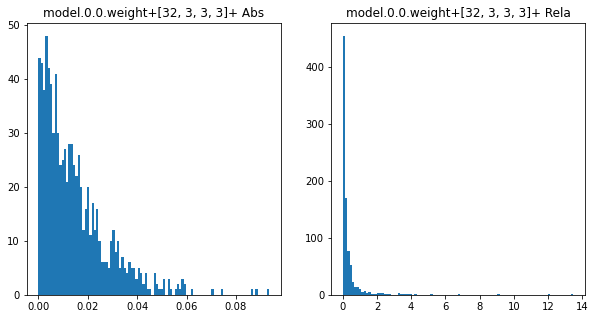

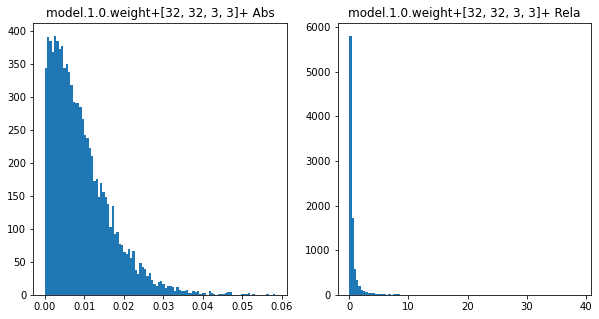

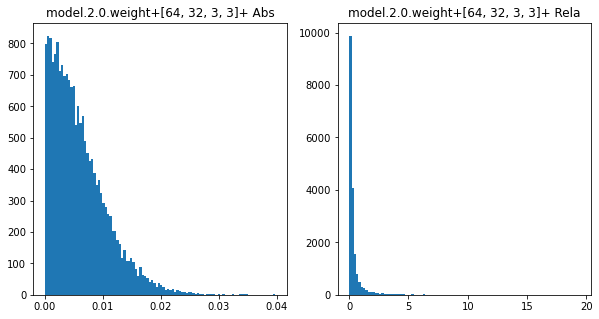

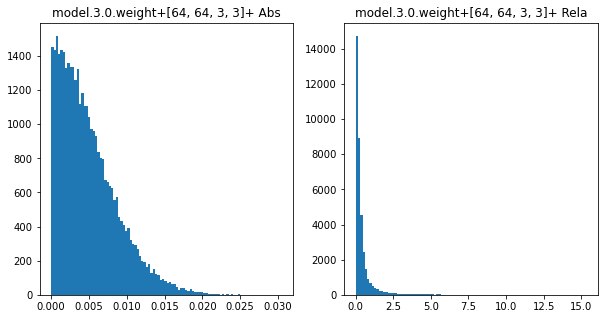

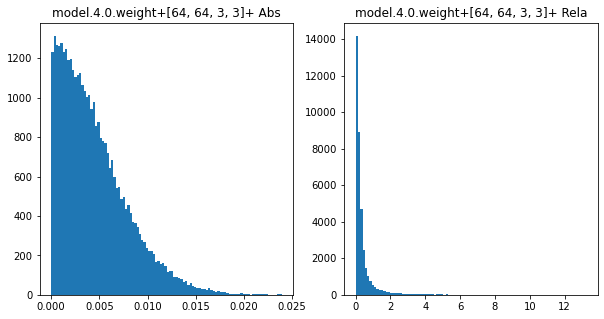

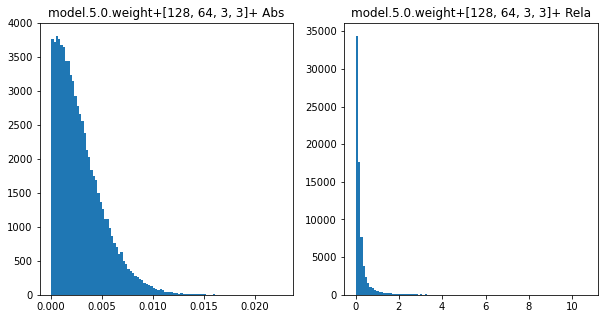

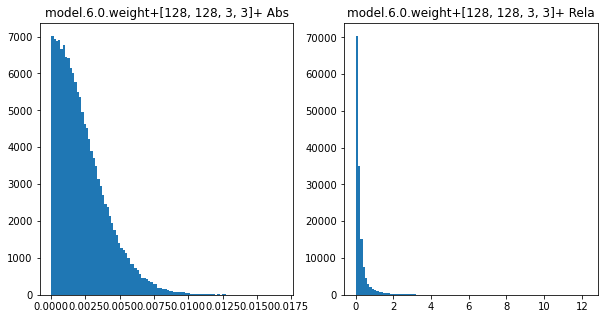

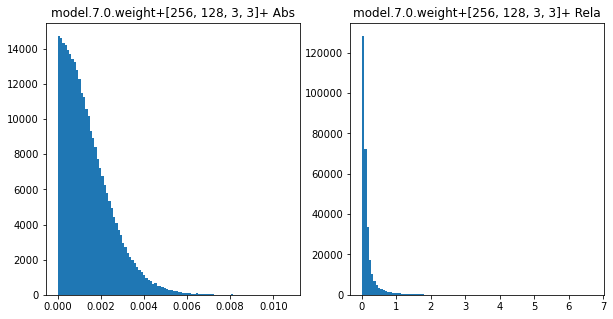

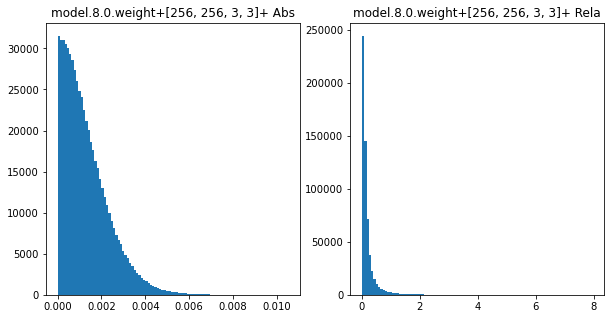

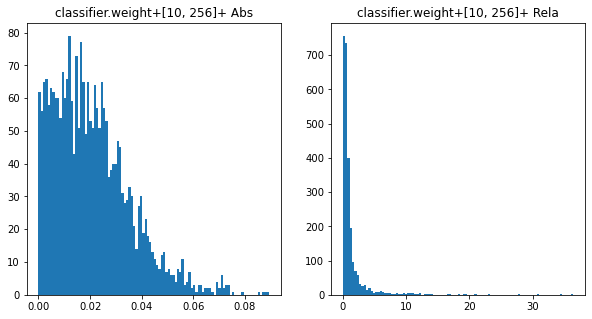

In [27]:
for k, v in diff.items():
    if ('wei' in k):
        size = v.size()
        abs_diff = v.abs()
        rela_diff = v.abs()/(old[k].abs()+1e-3)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,5])
        # sns.histplot(abs_diff.cpu().flatten().numpy(), ax=ax[0]).set_title(k+'+'+str(list(size))+'+ Abs')
        # sns.histplot(rela_diff.cpu().flatten().numpy(), ax=ax[1]).set_title(k+'+'+str(list(size))+'+ Rela')
        ax[0].hist(abs_diff.cpu().flatten().numpy(), bins=100)
        ax[0].set_title(k+'+'+str(list(size))+'+ Abs')
        
        ax[1].hist(rela_diff.cpu().flatten().numpy(), bins=100)
        ax[1].set_title(k+'+'+str(list(size))+'+ Rela')
        plt.show()
    

In [3]:
def show_bn(model):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            print('Running Mean:', m.running_mean, 'Running Var:', m.running_var)
            break

In [4]:
print(new_w_avg['model.0.1.running_mean'], new_w_avg['model.0.1.running_var'])

tensor([ 1.2355e-01,  3.8507e-02, -3.4388e-02, -3.6896e-02,  7.0751e-02,
        -3.4599e-02,  4.8286e-03,  4.9271e-03, -1.2562e-01,  1.6839e-02,
        -2.4223e-02, -4.9445e-02,  2.3106e-02,  8.8917e-02,  1.5726e-04,
         3.8776e-03, -1.3761e-02, -6.4845e-02,  4.7727e-02,  1.2506e-02,
         1.4246e-04,  6.4401e-02, -9.2369e-05, -1.8922e-02,  3.9942e-02,
         9.9110e-02,  8.0049e-02,  2.4175e-01,  4.9825e-02,  2.0308e-03,
         2.5246e-03, -4.6239e-02], device='cuda:0') tensor([0.4260, 0.2529, 0.4706, 0.4681, 0.5085, 0.6834, 0.9793, 0.4199, 0.4733,
        0.6038, 0.5654, 0.2564, 0.5400, 0.3739, 0.2197, 0.2237, 0.3815, 0.3247,
        0.2897, 0.4759, 0.4451, 0.2830, 0.5906, 0.3734, 0.1852, 0.3538, 0.2990,
        1.3860, 0.3351, 0.3322, 0.1309, 0.3896], device='cuda:0')


In [5]:
net_biasbn = copy.deepcopy(net)
biasbn_device = {'net': net_biasbn, 'test_loss_tracker':[], 'test_acc_tracker':[]}
test(0, biasbn_device, False)

net_biasbn.load_state_dict(new_w_avg)
biasbn_device = {'net': net_biasbn, 'test_loss_tracker':[], 'test_acc_tracker':[]}
show_bn(biasbn_device['net'])
test(0, biasbn_device, False)

 | Test Loss: 2.303 | Test Acc: 10.000

Running Mean: tensor([ 1.2355e-01,  3.8507e-02, -3.4388e-02, -3.6896e-02,  7.0751e-02,
        -3.4599e-02,  4.8286e-03,  4.9271e-03, -1.2562e-01,  1.6839e-02,
        -2.4223e-02, -4.9445e-02,  2.3106e-02,  8.8917e-02,  1.5726e-04,
         3.8776e-03, -1.3761e-02, -6.4845e-02,  4.7727e-02,  1.2506e-02,
         1.4246e-04,  6.4401e-02, -9.2369e-05, -1.8922e-02,  3.9942e-02,
         9.9110e-02,  8.0049e-02,  2.4175e-01,  4.9825e-02,  2.0308e-03,
         2.5246e-03, -4.6239e-02], device='cuda:0') Running Var: tensor([0.4260, 0.2529, 0.4706, 0.4681, 0.5085, 0.6834, 0.9793, 0.4199, 0.4733,
        0.6038, 0.5654, 0.2564, 0.5400, 0.3739, 0.2197, 0.2237, 0.3815, 0.3247,
        0.2897, 0.4759, 0.4451, 0.2830, 0.5906, 0.3734, 0.1852, 0.3538, 0.2990,
        1.3860, 0.3351, 0.3322, 0.1309, 0.3896], device='cuda:0')
 | Test Loss: 2.395 | Test Acc: 29.620



(2.395121251480489, 29.62)

In [6]:
net_debiasbn = copy.deepcopy(net)
net_debiasbn.load_state_dict(new_w_avg)
debiasbn_device = {'net': net_debiasbn, 'test_loss_tracker':[], 'test_acc_tracker':[]}
show_bn(net_debiasbn)
test_loss, test_acc = test(0, debiasbn_device, False)
print('=====> Start Check, Loss: %.12f, Acc: %.3f'%(test_loss, test_acc))

## Update the running mean and running variance

overall_trainloader = torch.utils.data.DataLoader(trainset,
                                                 batch_size=128,
                                                 shuffle=True,
                                                 num_workers=2)
debias_epochs = 5


for epoch_idx in range(debias_epochs):
    debiasbn_device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(overall_trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = debiasbn_device['net'](inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        if batch_idx%100==0:
            print('Debias finetune on Train| Epoch: %d | Loss: %.6f, Acc: %.2f'%(epoch_idx, loss, acc))
    
    show_bn(debiasbn_device['net'])
    test_loss, test_acc = test(0, debiasbn_device, False)
    print('=====> Epoch: %d, Loss: %.12f, Acc: %.3f'%(epoch_idx, test_loss, test_acc))
    
            

Running Mean: tensor([ 1.2355e-01,  3.8507e-02, -3.4388e-02, -3.6896e-02,  7.0751e-02,
        -3.4599e-02,  4.8286e-03,  4.9271e-03, -1.2562e-01,  1.6839e-02,
        -2.4223e-02, -4.9445e-02,  2.3106e-02,  8.8917e-02,  1.5726e-04,
         3.8776e-03, -1.3761e-02, -6.4845e-02,  4.7727e-02,  1.2506e-02,
         1.4246e-04,  6.4401e-02, -9.2369e-05, -1.8922e-02,  3.9942e-02,
         9.9110e-02,  8.0049e-02,  2.4175e-01,  4.9825e-02,  2.0308e-03,
         2.5246e-03, -4.6239e-02], device='cuda:0') Running Var: tensor([0.4260, 0.2529, 0.4706, 0.4681, 0.5085, 0.6834, 0.9793, 0.4199, 0.4733,
        0.6038, 0.5654, 0.2564, 0.5400, 0.3739, 0.2197, 0.2237, 0.3815, 0.3247,
        0.2897, 0.4759, 0.4451, 0.2830, 0.5906, 0.3734, 0.1852, 0.3538, 0.2990,
        1.3860, 0.3351, 0.3322, 0.1309, 0.3896], device='cuda:0')
 | Test Loss: 2.395 | Test Acc: 29.620

=====> Start Check, Loss: 2.395121251480, Acc: 29.620
Debias finetune on Train| Epoch: 0 | Loss: 1.349739, Acc: 49.22
Debias finetune on 

In [ ]:
# get di images
inv_batchsize = 10
all_inv_image = []
for device in round_devices:
    di= DeepInversionClass(bs=inv_batchsize, net_teacher=device['net'], path='./test')
    inv_image, inv_target = di.get_images(net_student=None, 
                                          reset_inputs=True, reset_targets=True, reset_opt=True)
    device['inv_image'] = inv_image
    all_inv_image.append(inv_image)
    
all_inv_image_tensor = torch.cat(all_inv_image)



# finetune on the inversed images
net_invbn = copy.deepcopy(net)
net_invbn.load_state_dict(new_w_avg)
invbn_device = {'net': net_invbn, 'test_loss_tracker':[], 'test_acc_tracker':[]}
show_bn(net_invbn)
test_loss, test_acc = test(0, invbn_device, False)
print('=====> Start Check, Loss: %.12f, Acc: %.3f'%(test_loss, test_acc))


## Update the running mean and running variance
invbn_epochs = 100


for epoch_idx in range(invbn_epochs):
    invbn_device['net'].train()
    train_loss, correct, total = 0, 0, 0

    # inputs, targets = inputs.cuda(), targets.cuda()
    inputs = all_inv_image_tensor
    outputs = invbn_device['net'](inputs)
    # loss = criterion(outputs, targets)
    # train_loss += loss.item()
    # loss = train_loss / (batch_idx + 1)
    # _, predicted = outputs.max(1)
    # total += targets.size(0)
    # correct += predicted.eq(targets).sum().item()
    # acc = 100. * correct / total
    # if batch_idx%100==0:
    #     print('Debias finetune on Train| Epoch: %d | Loss: %.6f, Acc: %.2f'%(epoch_idx, loss, acc))

    show_bn(invbn_device['net'])
    test_loss, test_acc = test(0, invbn_device, False)
    print('=====> Epoch: %d, Loss: %.12f, Acc: %.3f'%(epoch_idx, test_loss, test_acc))

-------------------- 2000 ------------------
R_feature: 3.459e+00, R_cross: 0.000e+00, R_total: 3.460e+01
-------------------- 2000 ------------------
R_feature: 3.568e+00, R_cross: 0.000e+00, R_total: 3.569e+01
-------------------- 2000 ------------------
R_feature: 3.724e+00, R_cross: 0.000e+00, R_total: 3.726e+01
-------------------- 2000 ------------------
R_feature: 4.246e+00, R_cross: 0.000e+00, R_total: 4.247e+01
-------------------- 2000 ------------------
R_feature: 3.404e+00, R_cross: 0.000e+00, R_total: 3.405e+01
-------------------- 2000 ------------------
R_feature: 3.790e+00, R_cross: 0.000e+00, R_total: 3.792e+01
-------------------- 2000 ------------------
R_feature: 3.715e+00, R_cross: 0.000e+00, R_total: 3.716e+01
-------------------- 2000 ------------------
R_feature: 3.476e+00, R_cross: 0.000e+00, R_total: 3.477e+01
-------------------- 2000 ------------------
R_feature: 3.684e+00, R_cross: 0.000e+00, R_total: 3.686e+01
-------------------- 2000 ------------------
R

In [8]:
def cal_num_para_inbn(model):
    total_num = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            total_num += m.running_mean.nelement()*2
    return total_num

cal_num_para_inbn(net)

2048